<a href="https://www.kaggle.com/code/kamalapousajja/obesity-risk-prediction?scriptVersionId=166157866" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Multi-Classification Prediction of Obesity Risk

**Goal:**

The notebook has the Multiclass Classification with an Obesity Risk competition, Playground Season-4 Episode-2. The goal of this competition is to use various factors to predict obesity risk in individuals, which is related to cardiovascular disease.

**About the Dataset:**

The data consist of the estimation of obesity levels in people from the countries of Mexico, Peru and Colombia, with ages between 14 and 61 and diverse eating habits and physical condition.

Of the total data, 77% was synthetically generated using the Weka tool and the SMOTE filter, while the remaining 23% was directly collected from users through a web platform. [Obesity risk dataset](https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster).


**The Features of this dataset include:**

* FCVC = 'Frequency of consumption of vegetables'
* NCP = 'Number of main meals'
* CH2O = 'Consumption of water daily'
* FAF = 'Physical activity frequency'
* TUE = 'Time using technology devices'
* FACV = 'Frequent consumption of high caloric food'
* CAEC = 'Consumption of food between meals'
* SMOKE = 'Smoker or not'
* SCC = 'Calories consumption monitoring'
* CALC = 'Consumption of alcohol'
* MTRANS = 'Transportation used'

**The Targets features include:**

* Underweight 
* Normal 
* Overweight level I 
* Overweight level II 
* Obesity type I 
* Obesity type II 
* Obesity type III 


In [1]:
# Import Libraries
import numpy as np 
import pandas as pd 

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics 
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

# Models
import xgboost
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import VotingClassifier

# Warnings
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
# Load data

train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')

In [3]:
# Load original data

original_data = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')

In [4]:
# Merge train data and orgiginal data 

train = pd.concat([train, original_data]).drop_duplicates()
train = train.reset_index(drop=True)
train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0.0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1.0,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2.0,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3.0,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4.0,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
# Get the information of the dataset

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22845 entries, 0 to 22844
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  float64
 1   Gender                          22845 non-null  object 
 2   Age                             22845 non-null  float64
 3   Height                          22845 non-null  float64
 4   Weight                          22845 non-null  float64
 5   family_history_with_overweight  22845 non-null  object 
 6   FAVC                            22845 non-null  object 
 7   FCVC                            22845 non-null  float64
 8   NCP                             22845 non-null  float64
 9   CAEC                            22845 non-null  object 
 10  SMOKE                           22845 non-null  object 
 11  CH2O                            22845 non-null  float64
 12  SCC                             

In [6]:
# Get the statistical summary of the numeric columns

train.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000,22845.000000
mean,10378.50000,23.888513,1.700467,87.793761,2.443675,2.755837,2.027165,0.984585,0.620984
std,5992.46278,5.755338,0.087865,26.363367,0.533392,0.711185,0.608479,0.839728,0.602802
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.755907,0.015860,0.000000
50%,10378.50000,22.815416,1.700000,84.000000,2.393837,3.000000,2.000000,1.000000,0.582840
75%,15567.75000,26.000000,1.763029,111.531208,3.000000,3.000000,2.531984,1.600431,1.000000
max,20757.00000,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [7]:
# Get the Statistical summary of the category columns

train.describe(include='object')

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
count,22845,22845,22845,22845,22845,22845,22845,22845,22845
unique,2,2,2,4,2,2,4,5,7
top,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III
freq,11457,18736,20826,19290,22556,22062,16446,18245,4370


# Data Cleaning

In [8]:
# Rename of the columns of the train dataset

train.rename(columns={'family_history_with_overweight': 'Family_history',
                     'FAVC': 'High_cal_food', 
                     'FCVC' : 'Vege_food',
                     'NCP' : 'Main_meal',
                     'CAEC' : 'Food_between_meal',
                     'SMOKE' : 'Smoke',
                     'CH2O': 'Water_consumption',
                     'SCC': 'Calories_monitor',
                     'FAF': 'Physical_activity_frequency',
                     'TUE' : 'Time_using_electronic',
                     'CALC': 'Alcohol_consumption',
                     'MTRANS': "Transport",
                     'NObeyesdad': 'Obesity_level'}, 
             inplace=True)

train.head()

,id,Gender,Age,Height,Weight,Family_history,High_cal_food,Vege_food,Main_meal,Food_between_meal,Smoke,Water_consumption,Calories_monitor,Physical_activity_frequency,Time_using_electronic,Alcohol_consumption,Transport,Obesity_level
0,0.0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1.0,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2.0,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3.0,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4.0,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [9]:
# Rename of the columns of the test dataset

test.rename(columns={'family_history_with_overweight': 'Family_history',
                     'FAVC': 'High_cal_food', 
                     'FCVC' : 'Vege_food',
                     'NCP' : 'Main_meal',
                     'CAEC' : 'Food_between_meal',
                     'SMOKE' : 'Smoke',
                     'CH2O': 'Water_consumption',
                     'SCC': 'Calories_monitor',
                     'FAF': 'Physical_activity_frequency',
                     'TUE' : 'Time_using_electronic',
                     'CALC': 'Alcohol_consumption',
                     'MTRANS': "Transport",
                     'NObeyesdad': 'Obesity_level'}, 
                inplace=True)

test.head()

,id,Gender,Age,Height,Weight,Family_history,High_cal_food,Vege_food,Main_meal,Food_between_meal,Smoke,Water_consumption,Calories_monitor,Physical_activity_frequency,Time_using_electronic,Alcohol_consumption,Transport
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [10]:
# Change the label of the target and make sure we can convert them back for submission

map_target = {'Insufficient_Weight': 0,
              'Normal_Weight': 1,
              'Overweight_Level_I': 2,
              'Overweight_Level_II': 3,
              'Obesity_Type_I': 4,
              'Obesity_Type_II': 5,
              'Obesity_Type_III': 6,
             }

train['Obesity_level'] = train['Obesity_level'].map(map_target)

train.head()

,id,Gender,Age,Height,Weight,Family_history,High_cal_food,Vege_food,Main_meal,Food_between_meal,Smoke,Water_consumption,Calories_monitor,Physical_activity_frequency,Time_using_electronic,Alcohol_consumption,Transport,Obesity_level
0,0.0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,3
1,1.0,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,1
2,2.0,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,0
3,3.0,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,6
4,4.0,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,3


In [11]:
# Check the missing values of train dataset

train.isnull().sum()

id                             2087
Gender                            0
Age                               0
Height                            0
Weight                            0
Family_history                    0
High_cal_food                     0
Vege_food                         0
Main_meal                         0
Food_between_meal                 0
Smoke                             0
Water_consumption                 0
Calories_monitor                  0
Physical_activity_frequency       0
Time_using_electronic             0
Alcohol_consumption               0
Transport                         0
Obesity_level                     0
dtype: int64

In [12]:
# Check the missing values of test dataset

test.isnull().sum()

id                             0
Gender                         0
Age                            0
Height                         0
Weight                         0
Family_history                 0
High_cal_food                  0
Vege_food                      0
Main_meal                      0
Food_between_meal              0
Smoke                          0
Water_consumption              0
Calories_monitor               0
Physical_activity_frequency    0
Time_using_electronic          0
Alcohol_consumption            0
Transport                      0
dtype: int64

In [13]:
# Remove unneccessary column

train.drop('id',axis=1,inplace=True) 
test.drop('id',axis=1,inplace=True) 
train.head()

,Gender,Age,Height,Weight,Family_history,High_cal_food,Vege_food,Main_meal,Food_between_meal,Smoke,Water_consumption,Calories_monitor,Physical_activity_frequency,Time_using_electronic,Alcohol_consumption,Transport,Obesity_level
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,3
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,1
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,0
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,6
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,3


# Exploratory Data Analysis

Text(0.5, 1.0, 'The distribution of Obesity level')

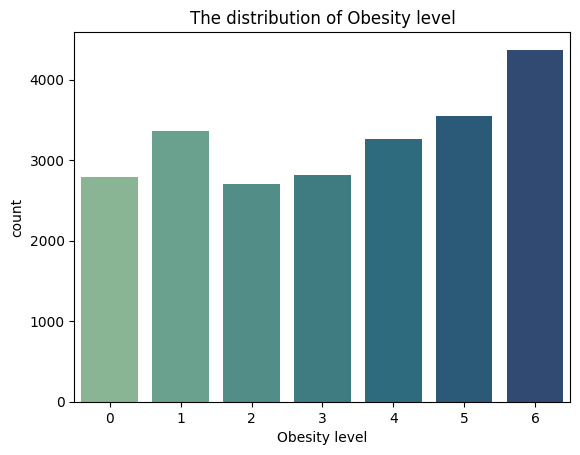

In [14]:
# Create a bar chart to see how many examples we have of each target types

sns.countplot(data = train, x = 'Obesity_level', palette = 'crest')

plt.xlabel('Obesity level')
plt.title('The distribution of Obesity level')

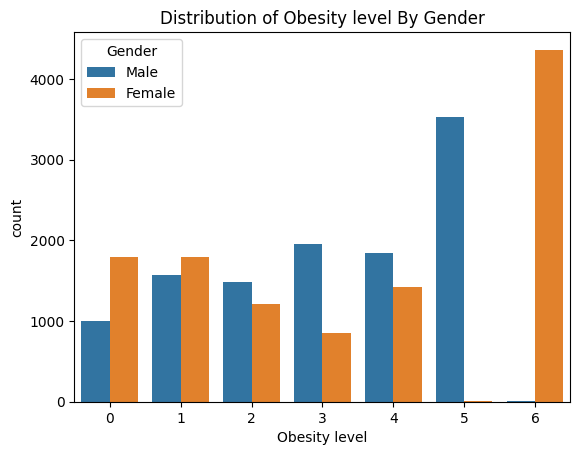

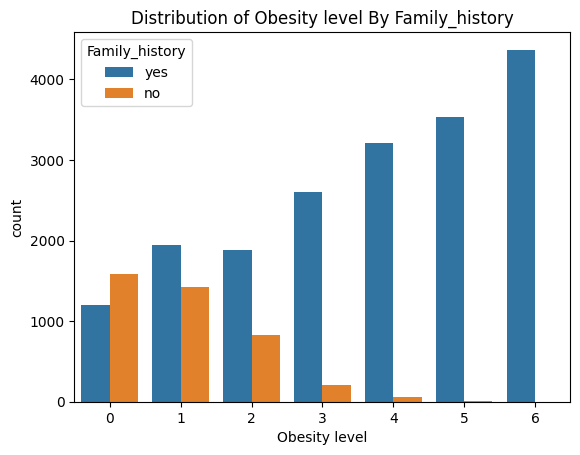

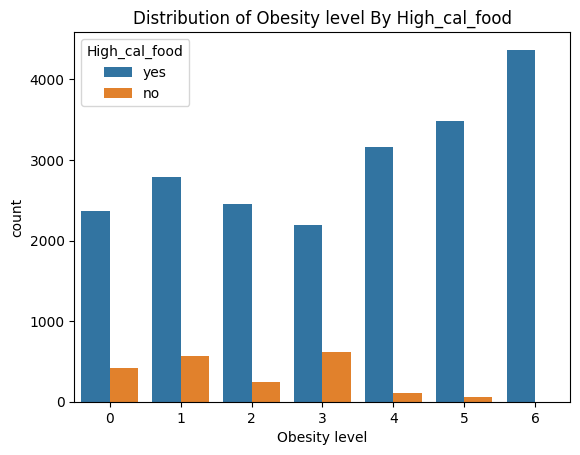

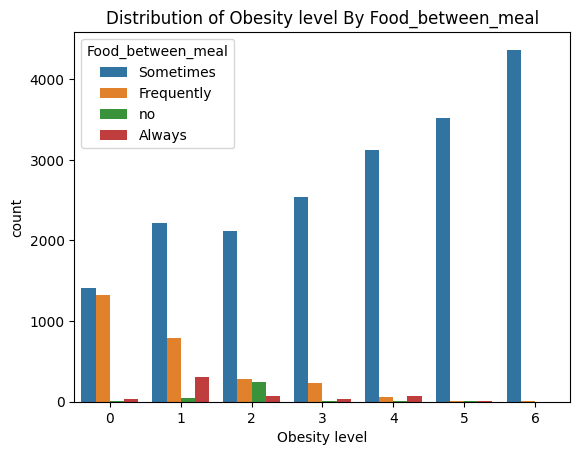

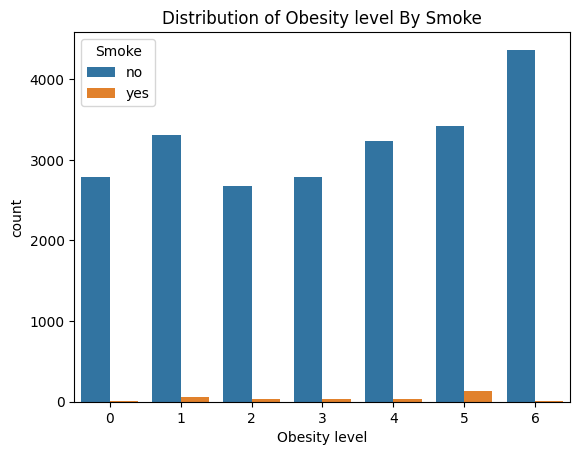

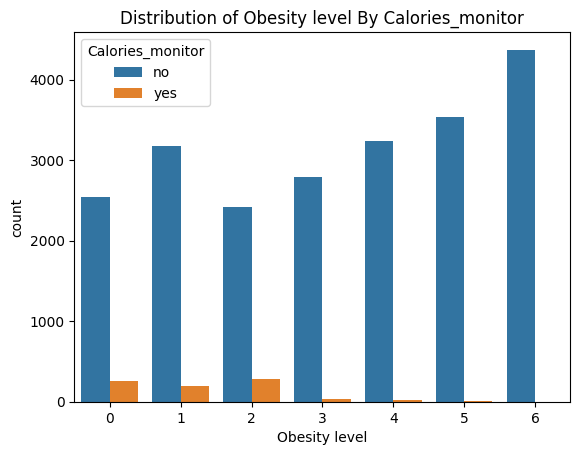

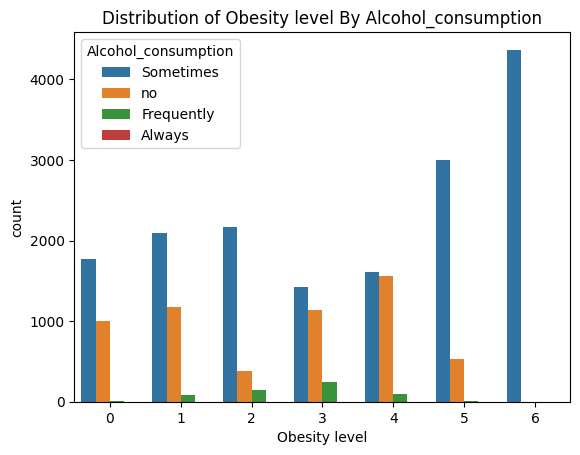

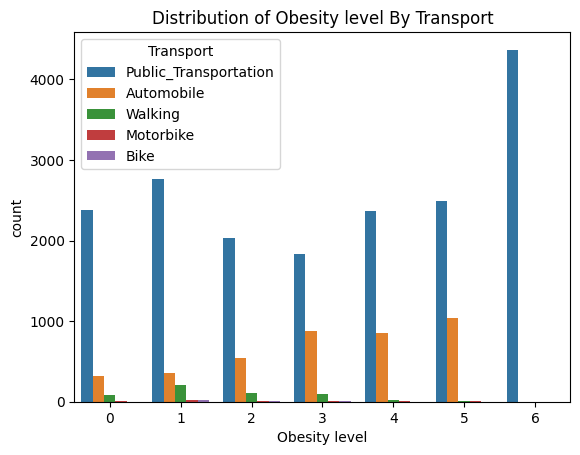

In [15]:
# Create bar chart to see the distributions of Obesity level in 'Categoric features' 

categoric_features = train.select_dtypes('object')

for feature in categoric_features:
    sns.countplot(data=train, x='Obesity_level', hue=feature)
    
    # Add some text for labels, title 
    plt.xlabel('Obesity level')
    plt.title(f'Distribution of Obesity level By {feature}')
    plt.show()

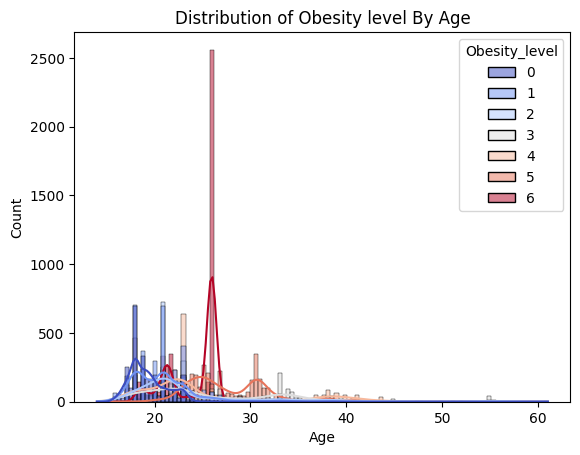

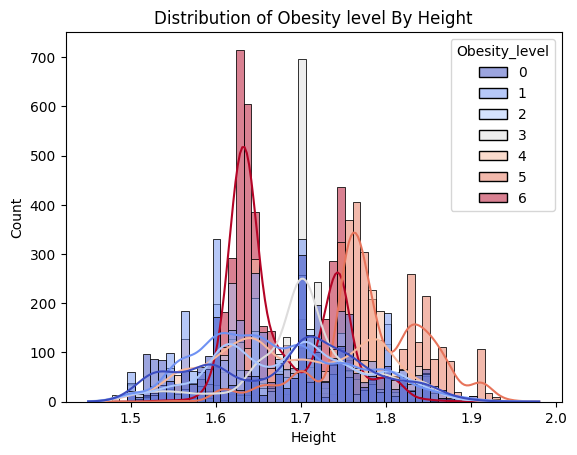

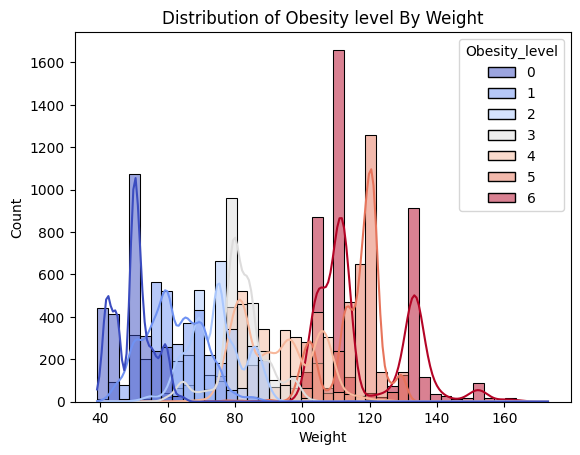

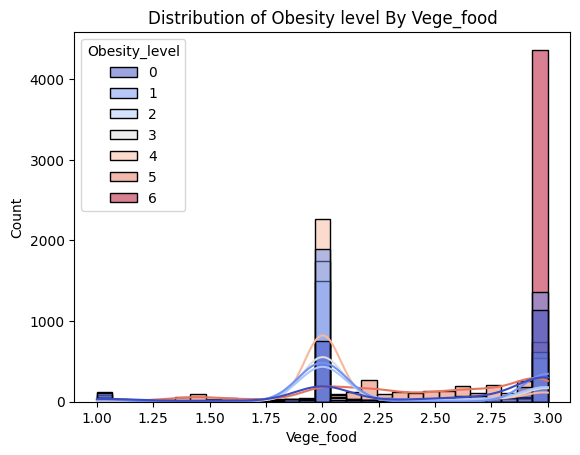

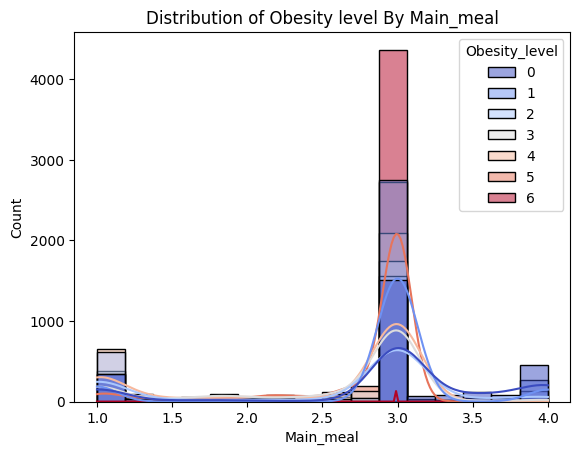

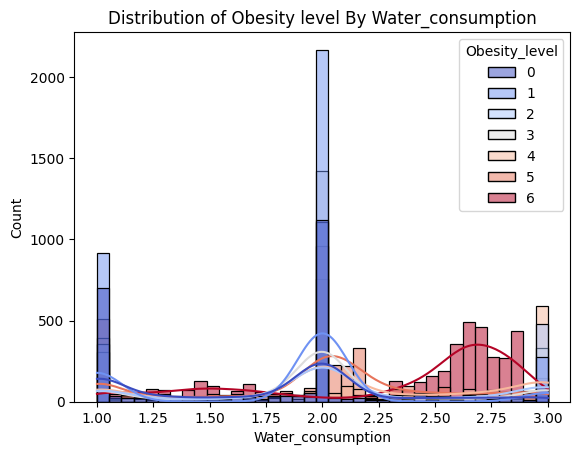

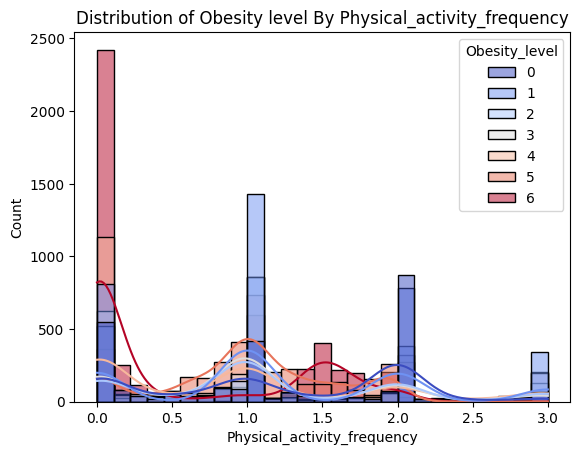

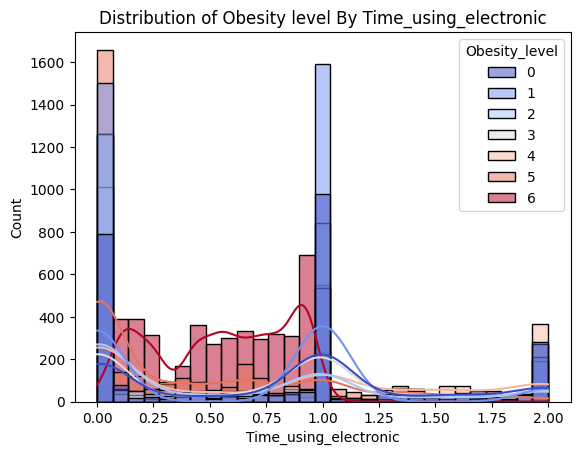

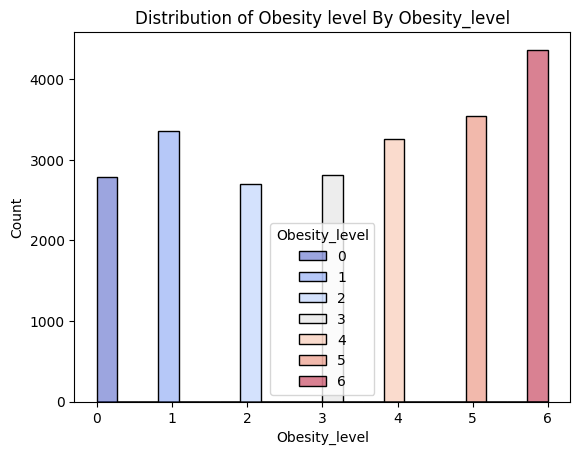

In [16]:
# Create histogram and kde to see univariate distributions of each feature 

numeric_features = train.select_dtypes('number')

for feature in numeric_features:
    sns.histplot(data=train, x=feature,hue='Obesity_level', kde=True, palette='coolwarm')
    plt.title(f'Distribution of Obesity level By {feature}')
    plt.show()

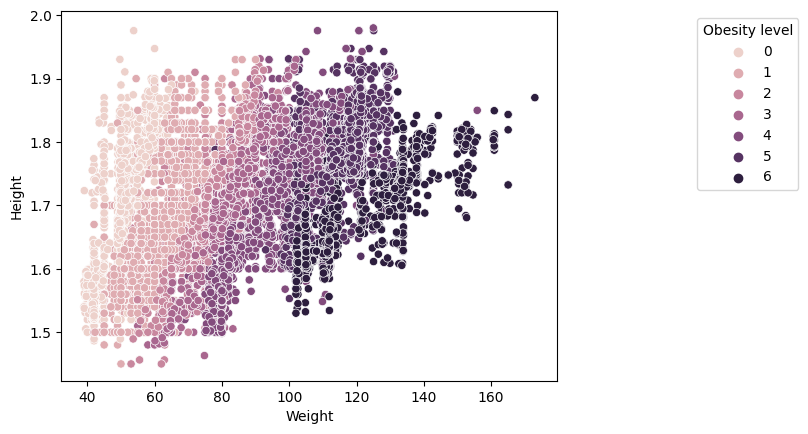

In [17]:
# Create a scatterplot of the Obesity level

sns.scatterplot(data=train, x='Weight', y='Height', hue='Obesity_level')

plt.legend(title='Obesity level',loc='upper right', bbox_to_anchor=(1.5, 1))

# Feature Engineering

In [18]:
# Create a copy before feature engineering

train2 = train.copy()
test2 = test.copy()

In [19]:
# Create new feature  of the 'Body Mass Index'  by using the 'Height' and 'Weight' features.

train2['BMI'] = train2['Weight'] / (train2['Height'] ** 2)

train2.head()

,Gender,Age,Height,Weight,Family_history,High_cal_food,Vege_food,Main_meal,Food_between_meal,Smoke,Water_consumption,Calories_monitor,Physical_activity_frequency,Time_using_electronic,Alcohol_consumption,Transport,Obesity_level,BMI
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,3,28.259565
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,1,23.422091
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,0,17.126706
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,6,44.855798
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,3,25.599151


In [20]:
# Create new feature of vegetables combine with all meal habits by using 'Frequency of consumption of vegetables' and 'Number of main meals' 

train2['Vege_MainMeal_group'] = train2['Vege_food'] * train2['Main_meal']

train2.head()

,Gender,Age,Height,Weight,Family_history,High_cal_food,Vege_food,Main_meal,Food_between_meal,Smoke,Water_consumption,Calories_monitor,Physical_activity_frequency,Time_using_electronic,Alcohol_consumption,Transport,Obesity_level,BMI,Vege_MainMeal_group
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,3,28.259565,5.966594
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,1,23.422091,6.000000
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,0,17.126706,2.654722
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,6,44.855798,9.000000
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,3,25.599151,5.282883


Text(0.5, 1.0, 'Distribution of BMI by Obesity level')

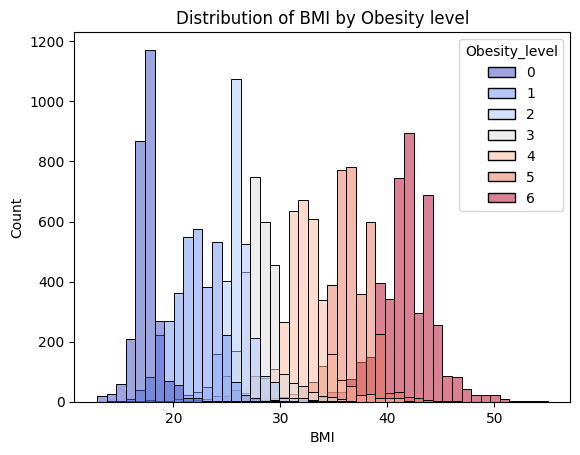

In [21]:
# Create histogram to see the distributions of Obesity level By BMI

sns.histplot(data=train2,x='BMI', hue='Obesity_level', palette='coolwarm')

plt.title('Distribution of BMI by Obesity level')

<Axes: xlabel='Vege_food', ylabel='Count'>

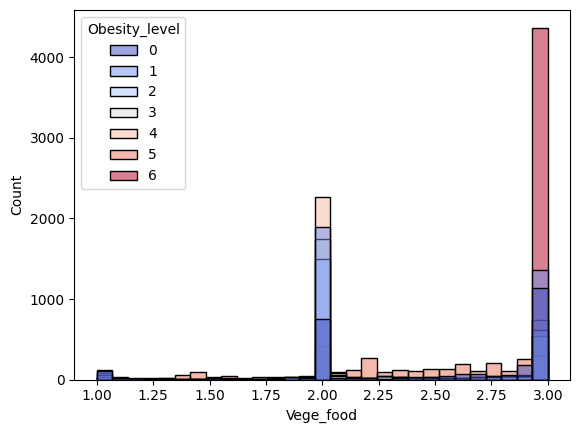

In [22]:
# Create histogram to see the distributions of Obesity level by 'Frequency of consumption of vegetables'

sns.histplot(data=train2,x='Vege_food', hue='Obesity_level', palette='coolwarm')

As this dataset had synthetic data generation. From the graph above, I will separate this data into groups, where the group will be 1,2,3, and the other group will be decimals.

In [23]:
# Create a group of 'Frequency of consumption of vegetables'

train2['Vege_bin'] = pd.cut(train2['Vege_food'], 
                            bins=[ 1,1.000001, 2,2.000001,3, float('inf')], 
                            labels=[0, 1, 2,3,4 ],
                            include_lowest=True, right=False)


In [24]:
# Check the data in the groups

pd.crosstab(train2['Vege_bin'],train2['Obesity_level']).T.style.background_gradient(cmap='coolwarm')

Vege_bin,0,1,2,3,4
Obesity_level,,,,,
0,57,241,726,715,1051
1,114,0,1892,3,1355
2,45,183,1452,461,562
3,33,135,1691,465,488
4,45,227,2202,551,236
5,14,517,271,2500,243
6,0,0,0,0,4370


In [25]:
# I will Double check the results of the 'pd.cut' function 
# by writing the another code that is easier to undersatand but a bit longer.

train2['Vege_group'] = ''
train2['Vege_group'].loc[(train2['Vege_food'] == 1)] = 0
train2['Vege_group'].loc[(train2['Vege_food'] > 1) & (train2['Vege_food'] < 2)] = 1
train2['Vege_group'].loc[(train2['Vege_food'] == 2)] = 2
train2['Vege_group'].loc[(train2['Vege_food'] > 2) & (train2['Vege_food'] < 3)] = 3
train2['Vege_group'].loc[(train2['Vege_food'] ==3)] = 4

In [26]:
# Check the data in the groups again

pd.crosstab(train2['Vege_group'],train2['Obesity_level']).T.style.background_gradient(cmap='coolwarm')

Vege_group,0,1,2,3,4
Obesity_level,,,,,
0,57,241,726,715,1051
1,114,0,1892,3,1355
2,45,183,1452,461,562
3,33,135,1691,465,488
4,45,227,2202,551,236
5,14,517,271,2500,243
6,0,0,0,0,4370


From the table, the results are the same, so I will use pd.cut to create a group.

In [27]:
# Remove 'Vege_group' column 

train2.drop(['Vege_group'],axis=1,inplace=True) 

train2.head()

,Gender,Age,Height,Weight,Family_history,High_cal_food,Vege_food,Main_meal,Food_between_meal,Smoke,Water_consumption,Calories_monitor,Physical_activity_frequency,Time_using_electronic,Alcohol_consumption,Transport,Obesity_level,BMI,Vege_MainMeal_group,Vege_bin
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,3,28.259565,5.966594,2
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,1,23.422091,6.000000,2
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,0,17.126706,2.654722,1
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,6,44.855798,9.000000,4
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,3,25.599151,5.282883,3


<Axes: xlabel='Main_meal', ylabel='Count'>

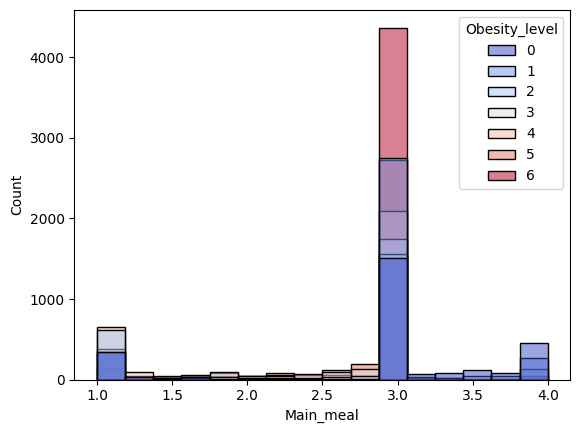

In [28]:
# Create histogram of the 'Main_meal' column

sns.histplot(data=train2, x= 'Main_meal', hue = 'Obesity_level', palette='coolwarm')

From the histogram above, I will separate this data into groups, where the group will be 1,2,3,4 and the other group will be decimals.

In [29]:
# Create a group of 'Main_meal' 

train2['Main_meal_bin'] = pd.cut(train2['Main_meal'], 
                                 bins=[ 1,1.000001, 2,2.000001,3,3.000001,4, float('inf')], 
                                 labels=[0, 1, 2,3,4,5,6 ],
                                 include_lowest=True, right=False)


In [30]:
# Check the data in the groups 

pd.crosstab(train2['Main_meal_bin'],train2['Obesity_level']).T.style.background_gradient(cmap='coolwarm')

Main_meal_bin,0,1,2,3,4,5,6
Obesity_level,,,,,,,
0,325,103,0,72,1472,434,384
1,337,0,5,1,2752,1,268
2,568,162,2,185,1500,195,91
3,323,285,2,563,1540,75,24
4,529,379,2,465,1869,4,13
5,73,226,0,818,2404,20,4
6,0,0,0,2,4368,0,0


<Axes: xlabel='Water_consumption', ylabel='Count'>

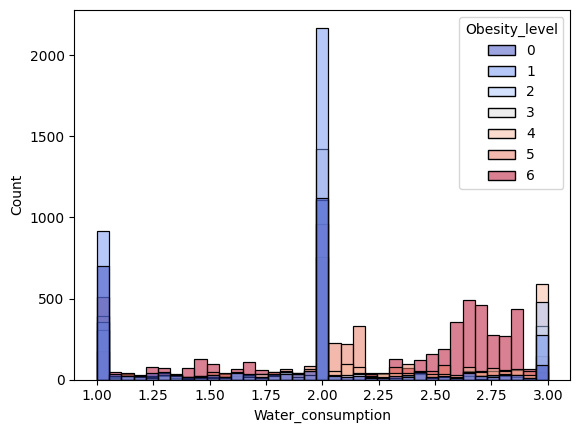

In [31]:
# Create histogram of the 'Water_consumption' column

sns.histplot(data=train2, x= 'Water_consumption', hue = 'Obesity_level', palette='coolwarm')

From the histogram above, I will separate this data into groups, where the group will be 1,2,3 and the other group will be decimals.

In [32]:
# Create a group of 'Water_consumption' 

train2['Water_bin'] = pd.cut(train2['Water_consumption'], 
                             bins=[ 1,1.000001,1.5,1.75, 2,2.000001,2.25,2.5,2.75,3, float('inf')], 
                             labels=[0, 1, 2,3,4,5,6,7,8,9 ],
                             include_lowest=True, right=False)


In [33]:
# Check the data in the groups 

pd.crosstab(train2['Water_bin'],train2['Obesity_level']).T.style.background_gradient(cmap='coolwarm')

Water_bin,0,1,2,3,4,5,6,7,8,9
Obesity_level,,,,,,,,,,
0,661,278,128,190,1059,104,108,97,109,56
1,915,0,0,0,2171,0,0,1,0,277
2,339,149,98,136,1076,126,97,106,126,450
3,289,136,122,223,1363,117,93,77,92,300
4,319,240,112,208,910,272,202,216,254,528
5,452,278,147,283,477,1039,267,270,227,105
6,28,674,325,168,5,94,452,1656,965,3


<Axes: xlabel='Physical_activity_frequency', ylabel='Count'>

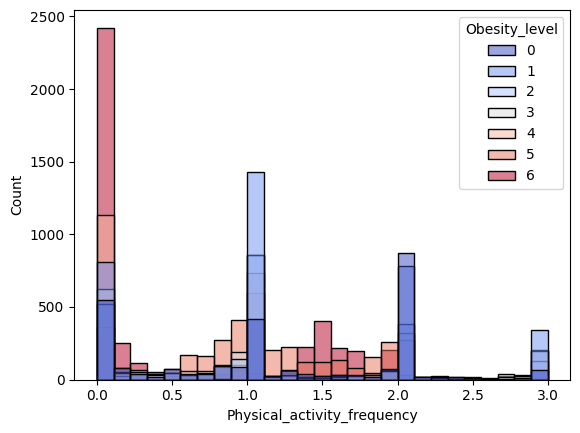

In [34]:
# Create histogram of the 'Physical_activity_frequency' column

sns.histplot(data=train2, x= 'Physical_activity_frequency', hue = 'Obesity_level', palette='coolwarm')

In [35]:
# Create a group of 'Physical_activity_frequency'

train2['Activity_bin'] = pd.cut(train2['Physical_activity_frequency'], 
                                bins=[ 0,0.000001,1,1.000001, 2,2.000001,3, float('inf')], 
                                labels=[0, 1, 2,3,4,5,6 ],
                                include_lowest=True, right=False)

In [36]:
# Check the data in the groups 

pd.crosstab(train2['Activity_bin'],train2['Obesity_level']).T.style.background_gradient(cmap='coolwarm')

Activity_bin,0,1,2,3,4,5,6
Obesity_level,,,,,,,
0,472,552,391,345,839,132,59
1,808,2,1429,2,783,0,340
2,463,535,823,222,364,111,185
3,576,577,817,266,306,155,115
4,991,619,674,351,247,205,174
5,320,1302,168,1720,29,4,2
6,1819,1160,12,1373,5,1,0


<Axes: xlabel='Time_using_electronic', ylabel='Count'>

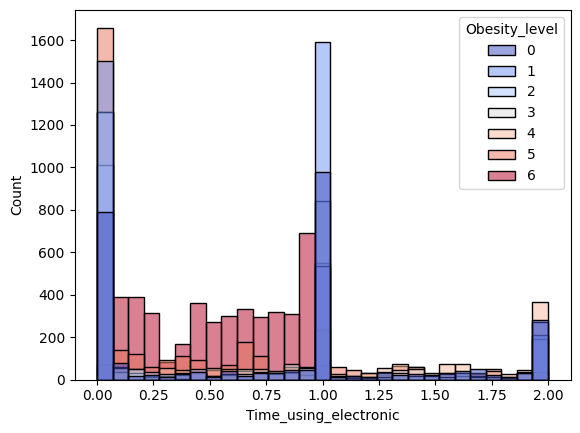

In [37]:
# Create histogram of the 'Time_using_electronic' column

sns.histplot(data=train2, x= 'Time_using_electronic', hue = 'Obesity_level', palette='coolwarm')

In [38]:
# Create a group of 'Time_using_electronic'

train2['Electronic_bin'] = pd.cut(train2['Time_using_electronic'], 
                           bins=[ 0,0.000001,1,1.000001, 2, float('inf')], 
                           labels=[0, 1, 2,3,4 ],
                            include_lowest=True, right=False)

In [39]:
# Check the data in the groups 

pd.crosstab(train2['Electronic_bin'],train2['Obesity_level']).T.style.background_gradient(cmap='coolwarm')

Electronic_bin,0,1,2,3,4
Obesity_level,,,,,
0,768,449,954,362,257
1,1500,1,1593,1,269
2,1224,548,501,239,191
3,978,528,796,348,162
4,1233,547,531,613,337
5,1378,1473,189,482,23
6,22,4291,51,4,2


<Axes: xlabel='Age', ylabel='Count'>

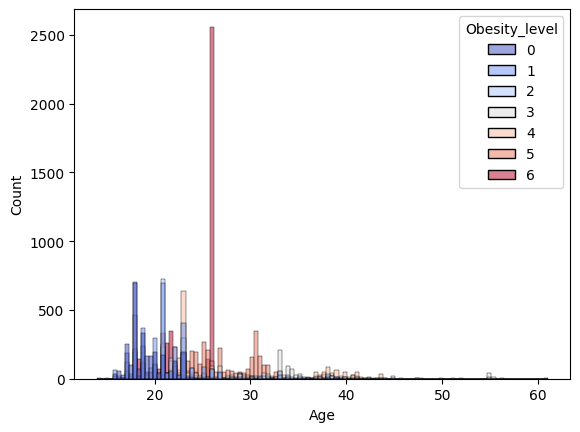

In [40]:
# Create histogram of the 'Age' column

sns.histplot(data=train2, x= 'Age', hue = 'Obesity_level', palette='coolwarm')

In [41]:
# Check the describe of 'Age' column

train2['Age'].describe()

count    22845.000000
mean        23.888513
std          5.755338
min         14.000000
25%         20.000000
50%         22.815416
75%         26.000000
max         61.000000
Name: Age, dtype: float64

In [42]:
# Create age group

bin_ages = []

for age in range(14,62,1):
    bin_ages.append(float(age))
    num = age + 0.00001
    bin_ages.append(num)

train2['Age_bin'] = pd.cut(train2['Age'], 
                           bins=bin_ages, 
                           include_lowest=True, right=False)

In [43]:
# Check the data in the groups 

pd.crosstab(train2['Age_bin'],train2['Obesity_level']).T.style.background_gradient(cmap='coolwarm')

Age_bin,"[14.0, 14.00001)","[15.0, 15.00001)","[16.0, 16.00001)","[16.00001, 17.0)","[17.0, 17.00001)","[17.00001, 18.0)","[18.0, 18.00001)","[18.00001, 19.0)","[19.0, 19.00001)","[19.00001, 20.0)","[20.0, 20.00001)","[20.00001, 21.0)","[21.0, 21.00001)","[21.00001, 22.0)","[22.0, 22.00001)","[22.00001, 23.0)","[23.0, 23.00001)","[23.00001, 24.0)","[24.0, 24.00001)","[24.00001, 25.0)","[25.0, 25.00001)","[25.00001, 26.0)","[26.0, 26.00001)","[26.00001, 27.0)","[27.0, 27.00001)","[27.00001, 28.0)","[28.0, 28.00001)","[28.00001, 29.0)","[29.0, 29.00001)","[29.00001, 30.0)","[30.0, 30.00001)","[30.00001, 31.0)","[31.0, 31.00001)","[31.00001, 32.0)","[32.0, 32.00001)","[32.00001, 33.0)","[33.0, 33.00001)","[33.00001, 34.0)","[34.0, 34.00001)","[34.00001, 35.0)","[35.0, 35.00001)","[35.00001, 36.0)","[36.0, 36.00001)","[36.00001, 37.0)","[37.0, 37.00001)","[37.00001, 38.0)","[38.0, 38.00001)","[38.00001, 39.0)","[39.0, 39.00001)","[39.00001, 40.0)","[40.0, 40.00001)","[40.00001, 41.0)","[41.0, 41.00001)","[41.00001, 42.0)","[42.0, 42.00001)","[42.00001, 43.0)","[43.0, 43.00001)","[43.00001, 44.0)","[44.0, 44.00001)","[44.00001, 45.0)","[45.0, 45.00001)","[45.00001, 46.0)","[46.0, 46.00001)","[46.00001, 47.0)","[47.00001, 48.0)","[48.0, 48.00001)","[49.00001, 50.0)","[50.0, 50.00001)","[50.00001, 51.0)","[51.0, 51.00001)","[52.0, 52.00001)","[53.00001, 54.0)","[55.0, 55.00001)","[55.00001, 56.0)","[56.0, 56.00001)","[61.0, 61.00001)"
Obesity_level,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,31,87,170,225,592,183,249,424,76,119,117,128,62,156,107,22,9,3,1,4,4,1,0,2,0,2,0,2,0,0,0,0,1,2,0,0,1,2,0,0,0,1,0,1,2,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,2,67,2,186,0,700,1,366,0,296,2,693,0,228,1,403,0,76,0,86,0,70,0,48,0,10,0,16,0,16,0,14,0,3,0,30,0,10,0,6,0,3,0,1,0,13,0,1,1,1,0,0,0,0,0,1,0,0,0,2,0,0,0,0,1,0,0,0,2,0,0,0,0,0,1
2,0,1,18,30,53,38,180,65,205,163,65,30,610,312,63,68,142,45,15,12,12,16,60,28,28,11,6,11,31,20,8,10,12,33,9,18,32,28,11,23,7,16,8,5,9,20,26,31,4,10,9,3,7,1,0,3,0,2,1,1,1,1,0,0,2,0,1,0,0,0,1,0,8,2,0,2
3,0,0,0,3,110,68,166,39,89,96,79,56,158,174,69,138,221,75,48,76,24,35,9,24,79,33,13,34,15,22,10,36,5,65,11,25,132,136,45,120,16,26,7,8,2,27,15,26,5,14,10,3,10,5,2,4,1,6,0,0,18,4,1,1,4,0,0,2,1,0,0,1,30,23,2,0
4,1,1,1,7,25,35,397,118,34,43,45,105,126,261,121,490,382,99,13,31,14,56,33,28,6,8,0,13,33,64,10,17,1,32,4,4,12,13,2,9,5,9,7,25,22,102,41,62,21,73,27,53,35,11,2,18,2,38,2,0,4,0,0,0,4,0,0,0,0,0,2,0,2,0,0,0
5,0,0,0,0,2,0,5,2,1,3,13,40,6,35,6,226,35,243,21,417,14,544,16,268,14,149,0,100,11,130,29,580,7,229,9,84,16,50,5,20,2,3,1,10,1,80,1,41,0,9,4,41,11,6,0,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,2,272,1,110,4,281,11,763,0,43,1,71,0,77,1,1016,1715,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
# Change the label

encoder = LabelEncoder()

train2['Age_bin2']= encoder.fit_transform(train2['Age_bin'])

In [45]:
# Check the data in the groups again

pd.crosstab(train2['Age_bin2'],train2['Obesity_level']).T.style.background_gradient(cmap='coolwarm')

Age_bin2,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75
Obesity_level,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,31,87,170,225,592,183,249,424,76,119,117,128,62,156,107,22,9,3,1,4,4,1,0,2,0,2,0,2,0,0,0,0,1,2,0,0,1,2,0,0,0,1,0,1,2,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,2,67,2,186,0,700,1,366,0,296,2,693,0,228,1,403,0,76,0,86,0,70,0,48,0,10,0,16,0,16,0,14,0,3,0,30,0,10,0,6,0,3,0,1,0,13,0,1,1,1,0,0,0,0,0,1,0,0,0,2,0,0,0,0,1,0,0,0,2,0,0,0,0,0,1
2,0,1,18,30,53,38,180,65,205,163,65,30,610,312,63,68,142,45,15,12,12,16,60,28,28,11,6,11,31,20,8,10,12,33,9,18,32,28,11,23,7,16,8,5,9,20,26,31,4,10,9,3,7,1,0,3,0,2,1,1,1,1,0,0,2,0,1,0,0,0,1,0,8,2,0,2
3,0,0,0,3,110,68,166,39,89,96,79,56,158,174,69,138,221,75,48,76,24,35,9,24,79,33,13,34,15,22,10,36,5,65,11,25,132,136,45,120,16,26,7,8,2,27,15,26,5,14,10,3,10,5,2,4,1,6,0,0,18,4,1,1,4,0,0,2,1,0,0,1,30,23,2,0
4,1,1,1,7,25,35,397,118,34,43,45,105,126,261,121,490,382,99,13,31,14,56,33,28,6,8,0,13,33,64,10,17,1,32,4,4,12,13,2,9,5,9,7,25,22,102,41,62,21,73,27,53,35,11,2,18,2,38,2,0,4,0,0,0,4,0,0,0,0,0,2,0,2,0,0,0
5,0,0,0,0,2,0,5,2,1,3,13,40,6,35,6,226,35,243,21,417,14,544,16,268,14,149,0,100,11,130,29,580,7,229,9,84,16,50,5,20,2,3,1,10,1,80,1,41,0,9,4,41,11,6,0,2,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,2,272,1,110,4,281,11,763,0,43,1,71,0,77,1,1016,1715,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


I will group the 'Age' column by:
- 1. The data that have the decimal number 
- 2. The data without decimal numbers

In [46]:
selected_number1 = []

for x in range(0,2,1):
    selected_number1.append(x)
for y in range(2,21,2):
    selected_number1.append(y)
    
selected_number1

[0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

From the 'Age_bin' and 'Age_bin2' column, 

I choose the 'selected_number1'  =  0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20

-Most of this column have the 'Age' WITHOUT decimal number

-Most of this target are Obesity_level 1

In [47]:
selected_number2 = []

for x in range(24,41,2):
    selected_number2.append(x)
    
selected_number2

[24, 26, 28, 30, 32, 34, 36, 38, 40]

From the 'Age_bin' and 'Age_bin2' column, 

I choose the 'selected_number2' = 24, 26, 28, 30, 32, 34, 36, 38, 40

-Most of this column have the 'Age' WITHOUT decimal number

-Most of this target are Obesity_level 3

In [48]:
selected_number3 = []

for x in range(42,59,2):
    selected_number3.append(x)
    
selected_number3

[42, 44, 46, 48, 50, 52, 54, 56, 58]

From the 'Age_bin' and 'Age_bin2' column, 

I choose the 'selected_number3' = 42, 44, 46, 48, 50, 52, 54, 56, 58

-Most of this column have the 'Age' WITHOUT decimal number

-Most of this target are Obesity_level 4

In [49]:
selected_number4 = []

for x in range(60,75,2):
    selected_number4.append(x)
    
selected_number4

[60, 62, 64, 66, 68, 70, 72, 74]

From the 'Age_bin' and 'Age_bin2' column,

I choose the 'selected_number4' = 60, 62, 64, 66, 68, 70, 72, 74

-Most of this column have the 'Age' WITHOUT decimal number

-Most of this target are Obesity_level 3

In [50]:
# Create age group

for number in selected_number1:
    train2['Age_below25_True'] = train2['Age_bin2'].isin(selected_number1)

for number in selected_number2:
    train2['Age_27_35_True'] = train2['Age_bin2'].isin(selected_number2)

for number in selected_number3:
    train2['Age_36_44_True'] = train2['Age_bin2'].isin(selected_number3)

for number in selected_number4:
    train2['Age_above45_True'] = train2['Age_bin2'].isin(selected_number4)

train2.head()

,Gender,Age,Height,Weight,Family_history,High_cal_food,Vege_food,Main_meal,Food_between_meal,Smoke,...,Main_meal_bin,Water_bin,Activity_bin,Electronic_bin,Age_bin,Age_bin2,Age_below25_True,Age_27_35_True,Age_36_44_True,Age_above45_True
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,...,3,8,0,1,"[24.00001, 25.0)",19,False,False,False,False
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,...,4,4,2,2,"[18.0, 18.00001)",6,True,False,False,False
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,...,1,3,1,3,"[18.0, 18.00001)",6,True,False,False,False
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,...,4,2,3,1,"[20.00001, 21.0)",11,False,False,False,False
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,...,1,3,3,1,"[31.00001, 32.0)",33,False,False,False,False


In [51]:
selected_number5 = []

for x in range(3,10,2):
    selected_number5.append(x)
    
selected_number5

[3, 5, 7, 9]

The reason of the selected numbers will be the same as above but this time is a group number of DECIMALS.

In [52]:
selected_number6 = []

for x in range(11,20,2):
    selected_number6.append(x)
    
selected_number6

[11, 13, 15, 17, 19]

In [53]:
selected_number7 = []

for x in range(23,36,2):
    selected_number7.append(x)
    
selected_number7

[23, 25, 27, 29, 31, 33, 35]

In [54]:
selected_number8 = []

for x in range(43,76,2):
    selected_number8.append(x)
    
selected_number8

[43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75]

In [55]:
# Create age group of decimals data (SMOTE)

for number in selected_number5:
    train2['Age_below20_SMOTE'] = train2['Age_bin2'].isin(selected_number5)

for number in selected_number6:
    train2['Age_20_24_SMOTE'] = train2['Age_bin2'].isin(selected_number6)

train2['Age_25_26_SMOTE'] = (train2['Age_bin2'] == 21) | (train2['Age_bin2'] == 22)

for number in selected_number7:
    train2['Age_27_35_SMOTE'] = train2['Age_bin2'].isin(selected_number7)

train2['Age_36_44_SMOTE'] = (train2['Age_bin2'] == 37) | (train2['Age_bin2'] == 39) |(train2['Age_bin2'] == 41)

for number in selected_number8:
    train2['Age_above45_SMOTE'] = train2['Age_bin2'].isin(selected_number8)

train2.head()

,Gender,Age,Height,Weight,Family_history,High_cal_food,Vege_food,Main_meal,Food_between_meal,Smoke,...,Age_below25_True,Age_27_35_True,Age_36_44_True,Age_above45_True,Age_below20_SMOTE,Age_20_24_SMOTE,Age_25_26_SMOTE,Age_27_35_SMOTE,Age_36_44_SMOTE,Age_above45_SMOTE
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,...,False,False,False,False,False,True,False,False,False,False
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,...,True,False,False,False,False,False,False,False,False,False
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,...,True,False,False,False,False,False,False,False,False,False
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,...,False,False,False,False,False,True,False,False,False,False
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,...,False,False,False,False,False,False,False,True,False,False


In [56]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22845 entries, 0 to 22844
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Gender                       22845 non-null  object  
 1   Age                          22845 non-null  float64 
 2   Height                       22845 non-null  float64 
 3   Weight                       22845 non-null  float64 
 4   Family_history               22845 non-null  object  
 5   High_cal_food                22845 non-null  object  
 6   Vege_food                    22845 non-null  float64 
 7   Main_meal                    22845 non-null  float64 
 8   Food_between_meal            22845 non-null  object  
 9   Smoke                        22845 non-null  object  
 10  Water_consumption            22845 non-null  float64 
 11  Calories_monitor             22845 non-null  object  
 12  Physical_activity_frequency  22845 non-null  float64 
 13  T

# Data Preprocessing for the model

In [57]:
# Create a copy before preprocessing data

final_data = train2.copy()

final_data.head()

,Gender,Age,Height,Weight,Family_history,High_cal_food,Vege_food,Main_meal,Food_between_meal,Smoke,...,Age_below25_True,Age_27_35_True,Age_36_44_True,Age_above45_True,Age_below20_SMOTE,Age_20_24_SMOTE,Age_25_26_SMOTE,Age_27_35_SMOTE,Age_36_44_SMOTE,Age_above45_SMOTE
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,...,False,False,False,False,False,True,False,False,False,False
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,...,True,False,False,False,False,False,False,False,False,False
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,...,True,False,False,False,False,False,False,False,False,False
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,...,False,False,False,False,False,True,False,False,False,False
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,...,False,False,False,False,False,False,False,True,False,False


In [58]:
# Check the column names

final_data.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'Family_history', 'High_cal_food',
       'Vege_food', 'Main_meal', 'Food_between_meal', 'Smoke',
       'Water_consumption', 'Calories_monitor', 'Physical_activity_frequency',
       'Time_using_electronic', 'Alcohol_consumption', 'Transport',
       'Obesity_level', 'BMI', 'Vege_MainMeal_group', 'Vege_bin',
       'Main_meal_bin', 'Water_bin', 'Activity_bin', 'Electronic_bin',
       'Age_bin', 'Age_bin2', 'Age_below25_True', 'Age_27_35_True',
       'Age_36_44_True', 'Age_above45_True', 'Age_below20_SMOTE',
       'Age_20_24_SMOTE', 'Age_25_26_SMOTE', 'Age_27_35_SMOTE',
       'Age_36_44_SMOTE', 'Age_above45_SMOTE'],
      dtype='object')

In [59]:
# Remove unneccessary column

final_data.drop(['Age_bin','Age_bin2'],axis=1,inplace=True) 

final_data.head()

,Gender,Age,Height,Weight,Family_history,High_cal_food,Vege_food,Main_meal,Food_between_meal,Smoke,...,Age_below25_True,Age_27_35_True,Age_36_44_True,Age_above45_True,Age_below20_SMOTE,Age_20_24_SMOTE,Age_25_26_SMOTE,Age_27_35_SMOTE,Age_36_44_SMOTE,Age_above45_SMOTE
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,...,False,False,False,False,False,True,False,False,False,False
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,...,True,False,False,False,False,False,False,False,False,False
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,...,True,False,False,False,False,False,False,False,False,False
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,...,False,False,False,False,False,True,False,False,False,False
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,...,False,False,False,False,False,False,False,True,False,False


In [60]:
# Create dummy variables from categories 
# (also can use One Hot Encoder)

final_data = pd.get_dummies(final_data)

final_data.head()

,Age,Height,Weight,Vege_food,Main_meal,Water_consumption,Physical_activity_frequency,Time_using_electronic,Obesity_level,BMI,...,Activity_bin_2,Activity_bin_3,Activity_bin_4,Activity_bin_5,Activity_bin_6,Electronic_bin_0,Electronic_bin_1,Electronic_bin_2,Electronic_bin_3,Electronic_bin_4
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,3,28.259565,...,False,False,False,False,False,False,True,False,False,False
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,1,23.422091,...,True,False,False,False,False,False,False,True,False,False
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,0,17.126706,...,False,False,False,False,False,False,False,False,True,False
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,6,44.855798,...,False,True,False,False,False,False,True,False,False,False
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,3,25.599151,...,False,True,False,False,False,False,True,False,False,False


In [61]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22845 entries, 0 to 22844
Data columns (total 78 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              22845 non-null  float64
 1   Height                           22845 non-null  float64
 2   Weight                           22845 non-null  float64
 3   Vege_food                        22845 non-null  float64
 4   Main_meal                        22845 non-null  float64
 5   Water_consumption                22845 non-null  float64
 6   Physical_activity_frequency      22845 non-null  float64
 7   Time_using_electronic            22845 non-null  float64
 8   Obesity_level                    22845 non-null  int64  
 9   BMI                              22845 non-null  float64
 10  Vege_MainMeal_group              22845 non-null  float64
 11  Age_below25_True                 22845 non-null  bool   
 12  Age_27_35_True    

**Test dataset**

-Create Feature engineering for the test dataset

-Also can use pipeline that should be easier

In [62]:
test2.head()

,Gender,Age,Height,Weight,Family_history,High_cal_food,Vege_food,Main_meal,Food_between_meal,Smoke,Water_consumption,Calories_monitor,Physical_activity_frequency,Time_using_electronic,Alcohol_consumption,Transport
0,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [63]:
# Create Feature engineering for the Test dataset

test2['BMI'] = test2['Weight'] / (test2['Height'] ** 2)

test2['Vege_MainMeal_group'] = test2['Vege_food'] * test2['Main_meal']

test2['Vege_bin'] = pd.cut(test2['Vege_food'], 
                           bins=[ 1,1.000001, 2,2.000001,3, float('inf')], 
                           labels=[0, 1, 2,3,4 ],
                            include_lowest=True, right=False)

test2['Main_meal_bin'] = pd.cut(test2['Main_meal'], 
                           bins=[ 1,1.000001, 2,2.000001,3,3.000001,4, float('inf')], 
                           labels=[0, 1, 2,3,4,5,6 ],
                            include_lowest=True, right=False)

test2['Water_bin'] = pd.cut(test2['Water_consumption'], 
                           bins=[ 1,1.000001,1.5,1.75, 2,2.000001,2.25,2.5,2.75,3, float('inf')], 
                           labels=[0, 1, 2,3,4,5,6,7,8,9 ],
                            include_lowest=True, right=False)


test2['Activity_bin'] = pd.cut(test2['Physical_activity_frequency'], 
                           bins=[ 0,0.000001,1,1.000001, 2,2.000001,3, float('inf')], 
                           labels=[0, 1, 2,3,4,5,6 ],
                            include_lowest=True, right=False)


test2['Electronic_bin'] = pd.cut(test2['Time_using_electronic'], 
                           bins=[ 0,0.000001,1,1.000001, 2, float('inf')], 
                           labels=[0, 1, 2,3,4 ],
                            include_lowest=True, right=False)

test2.head()

,Gender,Age,Height,Weight,Family_history,High_cal_food,Vege_food,Main_meal,Food_between_meal,Smoke,...,Time_using_electronic,Alcohol_consumption,Transport,BMI,Vege_MainMeal_group,Vege_bin,Main_meal_bin,Water_bin,Activity_bin,Electronic_bin
0,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,...,0.000000,Sometimes,Public_Transportation,35.315411,8.815848,3,4,8,1,0
1,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,...,0.000000,Sometimes,Public_Transportation,25.781250,2.000000,2,0,9,2,0
2,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,...,0.250502,Sometimes,Public_Transportation,41.324115,9.000000,4,4,7,0,1
3,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,...,0.000000,Sometimes,Public_Transportation,42.976937,5.955818,2,3,8,1,0
4,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,...,0.741069,Sometimes,Public_Transportation,39.584143,9.000000,4,4,7,0,1


In [64]:
# Create age bin

bin_ages = []

for age in range(14,62,1):
    bin_ages.append(float(age))
    num = age + 0.00001
    bin_ages.append(num)

test2['Age_bin'] = pd.cut(test2['Age'], 
                           bins=bin_ages, 
                            include_lowest=True, right=False)

encoder = LabelEncoder()

test2['Age_bin2']= encoder.fit_transform(test2['Age_bin'])

In [65]:
# Create age group (without decimals number)

for number in selected_number1:
    test2['Age_below25_True'] = test2['Age_bin2'].isin(selected_number1)

for number in selected_number2:
    test2['Age_27_35_True'] = test2['Age_bin2'].isin(selected_number2)

for number in selected_number3:
    test2['Age_36_44_True'] = test2['Age_bin2'].isin(selected_number3)

for number in selected_number4:
    test2['Age_above45_True'] = test2['Age_bin2'].isin(selected_number4)

test2.head()

,Gender,Age,Height,Weight,Family_history,High_cal_food,Vege_food,Main_meal,Food_between_meal,Smoke,...,Main_meal_bin,Water_bin,Activity_bin,Electronic_bin,Age_bin,Age_bin2,Age_below25_True,Age_27_35_True,Age_36_44_True,Age_above45_True
0,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,...,4,8,1,0,"[26.00001, 27.0)",23,False,False,False,False
1,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,...,0,9,2,0,"[21.0, 21.00001)",12,True,False,False,False
2,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,...,4,7,0,1,"[26.0, 26.00001)",22,False,False,False,False
3,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,...,3,8,1,0,"[20.00001, 21.0)",11,False,False,False,False
4,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,...,4,7,0,1,"[26.0, 26.00001)",22,False,False,False,False


In [66]:
# Create age group of SMOTE

for number in selected_number5:
    test2['Age_below20_SMOTE'] = test2['Age_bin2'].isin(selected_number5)

for number in selected_number6:
    test2['Age_20_24_SMOTE'] = test2['Age_bin2'].isin(selected_number6)

test2['Age_25_26_SMOTE'] = (test2['Age_bin2'] == 21) | (test2['Age_bin2'] == 22)

for number in selected_number7:
    test2['Age_27_35_SMOTE'] = test2['Age_bin2'].isin(selected_number7)

test2['Age_36_44_SMOTE'] = (test2['Age_bin2'] == 37) | (test2['Age_bin2'] == 39) |(test2['Age_bin2'] == 41)

for number in selected_number8:
    test2['Age_above45_SMOTE'] = test2['Age_bin2'].isin(selected_number8)

test2.head()

,Gender,Age,Height,Weight,Family_history,High_cal_food,Vege_food,Main_meal,Food_between_meal,Smoke,...,Age_below25_True,Age_27_35_True,Age_36_44_True,Age_above45_True,Age_below20_SMOTE,Age_20_24_SMOTE,Age_25_26_SMOTE,Age_27_35_SMOTE,Age_36_44_SMOTE,Age_above45_SMOTE
0,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,...,False,False,False,False,False,False,False,True,False,False
1,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,...,True,False,False,False,False,False,False,False,False,False
2,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,...,False,False,False,False,False,False,True,False,False,False
3,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,...,False,False,False,False,False,True,False,False,False,False
4,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,...,False,False,False,False,False,False,True,False,False,False


In [67]:
# Create a copy before preprocessing data

final_test= test2.copy()

final_test.head()

,Gender,Age,Height,Weight,Family_history,High_cal_food,Vege_food,Main_meal,Food_between_meal,Smoke,...,Age_below25_True,Age_27_35_True,Age_36_44_True,Age_above45_True,Age_below20_SMOTE,Age_20_24_SMOTE,Age_25_26_SMOTE,Age_27_35_SMOTE,Age_36_44_SMOTE,Age_above45_SMOTE
0,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,...,False,False,False,False,False,False,False,True,False,False
1,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,...,True,False,False,False,False,False,False,False,False,False
2,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,...,False,False,False,False,False,False,True,False,False,False
3,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,...,False,False,False,False,False,True,False,False,False,False
4,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,...,False,False,False,False,False,False,True,False,False,False


In [68]:
final_test.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'Family_history', 'High_cal_food',
       'Vege_food', 'Main_meal', 'Food_between_meal', 'Smoke',
       'Water_consumption', 'Calories_monitor', 'Physical_activity_frequency',
       'Time_using_electronic', 'Alcohol_consumption', 'Transport', 'BMI',
       'Vege_MainMeal_group', 'Vege_bin', 'Main_meal_bin', 'Water_bin',
       'Activity_bin', 'Electronic_bin', 'Age_bin', 'Age_bin2',
       'Age_below25_True', 'Age_27_35_True', 'Age_36_44_True',
       'Age_above45_True', 'Age_below20_SMOTE', 'Age_20_24_SMOTE',
       'Age_25_26_SMOTE', 'Age_27_35_SMOTE', 'Age_36_44_SMOTE',
       'Age_above45_SMOTE'],
      dtype='object')

In [69]:
# Remove unneccessary column

final_test.drop(['Age_bin','Age_bin2'],axis=1,inplace=True) 

final_test.head()

,Gender,Age,Height,Weight,Family_history,High_cal_food,Vege_food,Main_meal,Food_between_meal,Smoke,...,Age_below25_True,Age_27_35_True,Age_36_44_True,Age_above45_True,Age_below20_SMOTE,Age_20_24_SMOTE,Age_25_26_SMOTE,Age_27_35_SMOTE,Age_36_44_SMOTE,Age_above45_SMOTE
0,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,...,False,False,False,False,False,False,False,True,False,False
1,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,...,True,False,False,False,False,False,False,False,False,False
2,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,...,False,False,False,False,False,False,True,False,False,False
3,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,...,False,False,False,False,False,True,False,False,False,False
4,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,...,False,False,False,False,False,False,True,False,False,False


In [70]:
# Create dummy variables from categories 

final_test = pd.get_dummies(final_test)

final_test.head()

,Age,Height,Weight,Vege_food,Main_meal,Water_consumption,Physical_activity_frequency,Time_using_electronic,BMI,Vege_MainMeal_group,...,Activity_bin_2,Activity_bin_3,Activity_bin_4,Activity_bin_5,Activity_bin_6,Electronic_bin_0,Electronic_bin_1,Electronic_bin_2,Electronic_bin_3,Electronic_bin_4
0,26.899886,1.848294,120.644178,2.938616,3.000000,2.825629,0.855400,0.000000,35.315411,8.815848,...,False,False,False,False,False,True,False,False,False,False
1,21.000000,1.600000,66.000000,2.000000,1.000000,3.000000,1.000000,0.000000,25.781250,2.000000,...,True,False,False,False,False,True,False,False,False,False
2,26.000000,1.643355,111.600553,3.000000,3.000000,2.621877,0.000000,0.250502,41.324115,9.000000,...,False,False,False,False,False,False,True,False,False,False
3,20.979254,1.553127,103.669116,2.000000,2.977909,2.786417,0.094851,0.000000,42.976937,5.955818,...,False,False,False,False,False,True,False,False,False,False
4,26.000000,1.627396,104.835346,3.000000,3.000000,2.653531,0.000000,0.741069,39.584143,9.000000,...,False,False,False,False,False,False,True,False,False,False


In [71]:
# Define the features (X) and target (y)

X = final_data.drop('Obesity_level', axis=1)
y = final_data['Obesity_level']

# Split the data into training and test sets

X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [72]:
X.head()

,Age,Height,Weight,Vege_food,Main_meal,Water_consumption,Physical_activity_frequency,Time_using_electronic,BMI,Vege_MainMeal_group,...,Activity_bin_2,Activity_bin_3,Activity_bin_4,Activity_bin_5,Activity_bin_6,Electronic_bin_0,Electronic_bin_1,Electronic_bin_2,Electronic_bin_3,Electronic_bin_4
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,28.259565,5.966594,...,False,False,False,False,False,False,True,False,False,False
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,23.422091,6.000000,...,True,False,False,False,False,False,False,True,False,False
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,17.126706,2.654722,...,False,False,False,False,False,False,False,False,True,False
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,44.855798,9.000000,...,False,True,False,False,False,False,True,False,False,False
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,25.599151,5.282883,...,False,True,False,False,False,False,True,False,False,False


In [73]:
# Stratified K-Folds cross-validation

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [74]:
# Create baseline cv score of eXtream Gradient Boosting Classifier

xgb = XGBClassifier()

xgb.fit(X,y)

xgb_cv =cross_val_score(xgb,X,y, cv = cv,scoring = "accuracy").mean()
xgb_cv

0.9135478085588261

In [75]:
# Create baseline cv score of Light Gradient Boosting Machine

lgbm = LGBMClassifier(verbosity= -1)

lgbm.fit(X,y)

lgbm_cv =cross_val_score(lgbm,X,y, cv = cv,scoring = "accuracy").mean()
lgbm_cv

0.9131098843826525

# Hyperparameter Tuning

In [76]:
# # Run this code below for Hyperparameter Tuning of eXtream Gradient Boosting Classifier

# def objective(trial):
#     param = {"objective": "multi:softmax",  
#              "eval_metric": "mlogloss",  
#              "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
#              "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
#              "max_depth": trial.suggest_int("max_depth", 3, 20), 
#              "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#              "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#              "min_child_weight": trial.suggest_float("min_child_weight", 1, 10),
#              "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 1.0),
#              "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 1.0),
#              "random_state": 42
#             }

#     xgb_classifier = XGBClassifier(**param)
    
#     #xgb_classifier.fit(X_train, y_train)
#     xgb_classifier.fit(X, y)

#     #xgb_score = xgb_classifier.score(X_valid, y_valid)
#     xgb_score = cross_val_score(xgb_classifier,X,y, cv = cv,scoring = "accuracy").mean() 

#     return xgb_score

# # Set up the sampler for Optuna optimization
# sampler = optuna.samplers.TPESampler(seed=1)  

# # Create a study object for Optuna optimization
# study = optuna.create_study(direction="maximize", sampler=sampler)

# # Run the optimization process
# study.optimize(lambda trial: objective(trial), n_trials=100)

# # Get the best parameters after optimization
# best_params = study.best_params

# print('='*50)
# print(best_params)

In [77]:
# After run the code above, I will get the best parameter for the model

xgb_best_params = {'n_estimators': 1329, 
                    'learning_rate': 0.012045742217570335, 
                    'max_depth': 8, 
                    'colsample_bytree': 0.523223870382496, 
                    'subsample': 0.6813112107639734, 
                    'min_child_weight': 5.109003422046169, 
                    'reg_lambda': 0.24977690350108298, 
                    'reg_alpha': 0.007739010840318628}

xgb_tune = XGBClassifier(**xgb_best_params)

xgb_tune.fit(X,y)

xgb_cv =cross_val_score(xgb_tune,X,y, cv = cv,scoring = "accuracy").mean()
xgb_cv

0.9164802814364602

In [78]:
# # Run this code below for Hyperparameter Tuning of Light Gradient Boosting Machine

# def objective(trial):
#     param = {
#         "objective": "multiclass",
#         "metric": "multi_logloss",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "random_state": 42,
#         "num_class": 7,
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
#         "n_estimators": trial.suggest_int("n_estimators", 400, 1500),
#         "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
#         "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
#         "max_depth": trial.suggest_int("max_depth", 6, 20),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
#         "subsample": trial.suggest_float("subsample", 0.8, 1.0),
#         "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
#     }

#     lgbm_classifier = LGBMClassifier(**param)
    
#     #lgbm_classifier.fit(X_train, y_train)
#     lgbm_classifier.fit(X, y)

#     #lgbm_score = lgbm_classifier.score(X_valid, y_valid)
#     lgbm_score = cross_val_score(lgbm_classifier,X,y, cv = cv,scoring = "accuracy").mean() 

#     return lgbm_score

# # Set up the sampler for Optuna optimization
# sampler = optuna.samplers.TPESampler(seed=42)  

# # Create a study object for Optuna optimization
# study = optuna.create_study(direction="maximize", sampler=sampler)

# # Run the optimization process
# study.optimize(lambda trial: objective(trial), n_trials=100)

# # Get the best parameters after optimization
# best_params = study.best_params

# print('='*50)
# print(best_params)

In [79]:
# After run the code above, I will get the best parameter for the model

lgbm_best_params = {'objective': 'multiclass',    
                    'metric': 'multi_logloss',                   
                    'boosting_type': 'gbdt', 
                    'verbosity': -1,        
                    'random_state': 1,       
                    'num_class': 7,  
                    'learning_rate': 0.013627402281825358, 
                    'n_estimators': 654, 
                    'lambda_l1': 0.00842522915790025, 
                    'lambda_l2': 0.04165802338410897, 
                    'max_depth': 17, 
                    'colsample_bytree': 0.335310330331825, 
                    'subsample': 0.9263236630922722, 
                    'min_child_samples': 11
                   }

lgbm_tune = LGBMClassifier(**lgbm_best_params)

lgbm_tune.fit(X,y)

lgbm_cv =cross_val_score(lgbm_tune,X,y, cv = cv,scoring = "accuracy").mean()
lgbm_cv

# 0.9177497537814192 

0.9177497537814192

# Voting Classifier

In [80]:
# Define estimators

estimators = [('LGBM',lgbm_tune),
              ('XGB', xgb_tune),  
             ]

voting_model = VotingClassifier(estimators=estimators,
                                voting='soft')

voting_soft = voting_model.fit(X, y)

voting_cv = cross_val_score(voting_model,X,y, cv = cv,
                            scoring = "accuracy").mean()

voting_cv

# 0.9183625793743555

0.9178373577776329

In [81]:
# Make predictions on the test dataset

voting_predict = voting_model.predict(final_test)

In [82]:
# Create a submission file

submission_df = pd.DataFrame({'id': sample_submission['id'],
                              'NObeyesdad': voting_predict})

unmapping = {0:'Insufficient_Weight',
             1:'Normal_Weight',
             2:'Overweight_Level_I',
             3:'Overweight_Level_II',
             4:'Obesity_Type_I',
             5:'Obesity_Type_II',
             6:'Obesity_Type_III',
             }
    
submission_df['NObeyesdad'] = submission_df['NObeyesdad'].map(unmapping)

submission_df.to_csv('submission_vote.csv', index=False)

submission_df.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


In [83]:
# Make predictions on the test dataset by using lgbm model

lgbm_predict = lgbm_tune.predict(final_test)

In [84]:
 # Create a submission file of lgbm model

submission_df = pd.DataFrame({'id': sample_submission['id'],
                              'NObeyesdad': lgbm_predict})

unmapping = {0:'Insufficient_Weight',
             1:'Normal_Weight',
             2:'Overweight_Level_I',
             3:'Overweight_Level_II',
             4:'Obesity_Type_I',
             5:'Obesity_Type_II',
             6:'Obesity_Type_III',
             }
    
submission_df['NObeyesdad'] = submission_df['NObeyesdad'].map(unmapping)

submission_df.to_csv('submission_lgbm.csv', index=False)

submission_df.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


**Conclusion:**

The difference between my notebook to others notebooks are:

- I create the group of data that have decimals numbers (SMOTE) and the group of data without decimals numbers.

- For the 'Age' column, they are a bit complicated but the group of SMOTE and group without decimals numbers, really help to improve the cv score. 

- I create only 2 new features that can improve the cv score. I tried to add another features but they didn't help to improve the cv score at all.

- Voting clasifier can help to improve the cv score to 0.9183625793743555

After this competition ended, I got rank of the Top 9% (320 / 3587)
